<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import io
import requests
from sklearn.cluster import KMeans
from datetime import datetime, date, timedelta
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
import tabloo

url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [32]:
# Для дальнейше работы нам нужен средний размер банковского депозита
avg_deposite = pd.read_html(io='https://www.cbr.ru/statistics/avgprocstav/')[0]['Ставка, %'].iloc[0]/1000000
# Ключавая ставка банка России
Key_Rate = pd.read_html(io='https://www.cbr.ru/hd_base/KeyRate/')[0]['Ставка'].iloc[0]/10000
# Текущая инфляция
Inflation = pd.read_html(io='https://xn----ctbjnaatncev9av3a8f8b.xn--p1ai/%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D1%8B-%D0%B8%D0%BD%D1%84%D0%BB%D1%8F%D1%86%D0%B8%D0%B8')[0].iloc[0][1:].max()/100

In [33]:
# Загрузили данные в дата фрейм
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('cp1251')), sep=';', header = 1)

In [34]:
#Смотрим какие есть занчения в шапке
df.columns.values

array(['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'ISIN', 'REGNUMBER',
       'LISTLEVEL', 'FACEVALUE', 'FACEUNIT', 'ISSUESIZE', 'IS_COLLATERAL',
       'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 'MATDATE',
       'IS_RII', 'EVENINGSESSION', 'MORNINGSESSION', 'DURATION',
       'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONFREQUENCY',
       'YIELDATWAP', 'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE',
       'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH',
       'ISSUEDATE', 'INITIALFACEVALUE', 'SECSUBTYPE', 'STARTDATEMOEX',
       'DAYSTOREDEMPTION', 'OFFERDATE', 'EMITENTNAME', 'INN', 'LOTSIZE',
       'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3',
       'RTH3', 'DISCOUNT1', 'LIMIT1', 'DISCOUNT2', 'LIMIT2', 'DISCOUNT3',
       'DISCOUNTL0', 'DISCOUNTH0'], dtype=object)

In [36]:
# Формируем дата фрейм под себя
bonds = df[['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'FACEVALUE', 'FACEUNIT', 'COUPONFREQUENCY', \
            'COUPONVALUE', 'COUPONPERCENT', 'PRICE', 'PRICE_RUB', 'HIGH_RISK', 'COUPONDATE', 'COUPONDAYSPASSED',\
            'COUPONLENGTH', 'LISTLEVEL', 'IS_QUALIFIED_INVESTORS', 'DAYSTOREDEMPTION']]
bonds

,SECID,SHORTNAME,NAME,TYPENAME,FACEVALUE,FACEUNIT,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE,PRICE_RUB,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,LISTLEVEL,IS_QUALIFIED_INVESTORS,DAYSTOREDEMPTION
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,"100,0",USD,4.0,"1,3125","5,250","103,18","7968,72",0,15.02.2022,69.0,92.0,3.0,0,296.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,"100,0",USD,4.0,"1,325","5,300","103,96","8118,78",0,05.02.2022,79.0,92.0,3.0,0,743.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,"1000,0",USD,4.0,"12,47","5,000","95,12","73822,02",0,22.03.2022,33.0,91.0,3.0,1,1094.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,"5000,0",CHF,1.0,"203,63",NaN,"104,71","444060,97",0,24.10.2022,91.0,365.0,NaN,1,1005.0
4,CH0374882816,GAZ-22 CHF,GAZ CAPITAL SA 2.25 19/07/22,Корпоративные еврооблигации,"5000,0",CHF,1.0,"112,5","2,250","99,65","427505,7",0,19.07.2022,188.0,365.0,NaN,1,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,XS2417684813,BCS12/23-8,BCS SP Plc Series 233,Корпоративные еврооблигации,"1250,0",USD,4.0,NaN,NaN,"100,0","96539,0",0,08.03.2022,54.0,98.0,3.0,1,684.0
2759,XS2418281742,BCSTR12/31,BCS SP Plc Series 2021-19,Корпоративные еврооблигации,"10000,0",USD,4.0,"32,5","1,300","100,0","772312,0",0,06.03.2022,48.0,90.0,3.0,1,3604.0
2760,XS2418791864,BCS12/24-G,BCS SP Plc Series 238,Корпоративные еврооблигации,"1250,0",USD,4.0,NaN,NaN,"100,0","96539,0",0,14.03.2022,45.0,95.0,3.0,1,1056.0
2761,XS2420560869,BCS01/25,BCS SP Plc Series 239,Корпоративные еврооблигации,"100000,0",RUB,4.0,NaN,NaN,"100,0","100000,0",0,15.04.2022,39.0,121.0,3.0,1,1088.0


In [37]:
#оцениваем тип данных
bonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2763 non-null   object 
 1   SHORTNAME               2763 non-null   object 
 2   NAME                    2763 non-null   object 
 3   TYPENAME                2763 non-null   object 
 4   FACEVALUE               2763 non-null   object 
 5   FACEUNIT                2763 non-null   object 
 6   COUPONFREQUENCY         2383 non-null   float64
 7   COUPONVALUE             2646 non-null   object 
 8   COUPONPERCENT           2643 non-null   object 
 9   PRICE                   2577 non-null   object 
 10  PRICE_RUB               2577 non-null   object 
 11  HIGH_RISK               2763 non-null   int64  
 12  COUPONDATE              2752 non-null   object 
 13  COUPONDAYSPASSED        2746 non-null   float64
 14  COUPONLENGTH            2752 non-null   

In [38]:
#Перевод данные в нужный нам формат
bonds = df[['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'FACEVALUE', 'FACEUNIT', 'COUPONFREQUENCY', \
            'COUPONVALUE', 'COUPONPERCENT', 'PRICE', 'PRICE_RUB', 'HIGH_RISK', 'COUPONDATE', 'COUPONDAYSPASSED',\
            'COUPONLENGTH', 'LISTLEVEL', 'IS_QUALIFIED_INVESTORS', 'DAYSTOREDEMPTION']]

bonds['FACEVALUE']=bonds['FACEVALUE'].str.replace(',', '.').astype(float)
bonds['COUPONVALUE']=bonds['COUPONVALUE'].str.replace(',', '.').astype(float)
bonds['COUPONPERCENT']=bonds['COUPONPERCENT'].str.replace(',', '.').astype(float)/100
bonds['PRICE']=bonds['PRICE'].str.replace(',', '.').astype(float)/100
bonds['PRICE_RUB']=bonds['PRICE_RUB'].str.replace(',', '.').astype(float)
bonds['COUPONDATE']=bonds['COUPONDATE'].str.replace('.', '')
bonds['COUPONDATE']=pd.to_datetime(bonds['COUPONDATE'], format='%d%m%Y')
bonds

C:\Users\nevge\AppData\Local\Temp/ipykernel_17960/3425421312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonds['FACEVALUE']=bonds['FACEVALUE'].str.replace(',', '.').astype(float)
C:\Users\nevge\AppData\Local\Temp/ipykernel_17960/3425421312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonds['COUPONVALUE']=bonds['COUPONVALUE'].str.replace(',', '.').astype(float)
C:\Users\nevge\AppData\Local\Temp/ipykernel_17960/3425421312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,SECID,SHORTNAME,NAME,TYPENAME,FACEVALUE,FACEUNIT,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE,PRICE_RUB,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,LISTLEVEL,IS_QUALIFIED_INVESTORS,DAYSTOREDEMPTION
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,100.0,USD,4.0,1.3125,0.0525,1.0318,7968.72,0,2022-02-15,69.0,92.0,3.0,0,296.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,100.0,USD,4.0,1.3250,0.0530,1.0396,8118.78,0,2022-02-05,79.0,92.0,3.0,0,743.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,1000.0,USD,4.0,12.4700,0.0500,0.9512,73822.02,0,2022-03-22,33.0,91.0,3.0,1,1094.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,5000.0,CHF,1.0,203.6300,NaN,1.0471,444060.97,0,2022-10-24,91.0,365.0,NaN,1,1005.0
4,CH0374882816,GAZ-22 CHF,GAZ CAPITAL SA 2.25 19/07/22,Корпоративные еврооблигации,5000.0,CHF,1.0,112.5000,0.0225,0.9965,427505.70,0,2022-07-19,188.0,365.0,NaN,1,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,XS2417684813,BCS12/23-8,BCS SP Plc Series 233,Корпоративные еврооблигации,1250.0,USD,4.0,NaN,NaN,1.0000,96539.00,0,2022-03-08,54.0,98.0,3.0,1,684.0
2759,XS2418281742,BCSTR12/31,BCS SP Plc Series 2021-19,Корпоративные еврооблигации,10000.0,USD,4.0,32.5000,0.0130,1.0000,772312.00,0,2022-03-06,48.0,90.0,3.0,1,3604.0
2760,XS2418791864,BCS12/24-G,BCS SP Plc Series 238,Корпоративные еврооблигации,1250.0,USD,4.0,NaN,NaN,1.0000,96539.00,0,2022-03-14,45.0,95.0,3.0,1,1056.0
2761,XS2420560869,BCS01/25,BCS SP Plc Series 239,Корпоративные еврооблигации,100000.0,RUB,4.0,NaN,NaN,1.0000,100000.00,0,2022-04-15,39.0,121.0,3.0,1,1088.0


In [39]:
# отбираем рублевые облигации
bonds = bonds[bonds['FACEUNIT']=='RUB']
bonds

,SECID,SHORTNAME,NAME,TYPENAME,FACEVALUE,FACEUNIT,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE,PRICE_RUB,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,LISTLEVEL,IS_QUALIFIED_INVESTORS,DAYSTOREDEMPTION
13,RU000A0JNYN1,МГор48-об,Гор.Обл.Займ Москвы 48 в.,Региональные облигации,1000.0,RUB,2.0,29.92,0.0600,0.9887,995.93,0,2022-06-11,43.0,182.0,1.0,0,139.0
14,RU000A0JQ5C5,НПФ 01,"""НПФ"" ООО об.сер. 01",Корпоративные облигации,1000.0,RUB,NaN,1000.55,0.0500,1.0000,1636.30,1,2029-05-06,4644.0,7304.0,3.0,0,2660.0
15,RU000A0JQ7Z2,РЖД-19 обл,"""Российские ЖД"" ОАО 19 обл.",Корпоративные облигации,1000.0,RUB,2.0,39.14,0.0785,0.9599,962.91,0,2022-07-11,13.0,182.0,2.0,0,897.0
16,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,Корпоративные облигации,1000.0,RUB,2.0,49.59,0.1000,1.0348,1053.98,0,2022-05-15,69.0,181.0,1.0,0,477.0
17,RU000A0JQAM6,ДОМ.РФ15об,ДОМ.РФ (АО) обл. сер. А15,Корпоративные облигации,1000.0,RUB,2.0,45.87,0.0925,1.1124,1145.60,0,2022-03-15,130.0,181.0,1.0,0,2427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,XS2388458403,BCS12/26-2,BCS SP Plc Series 215,Корпоративные еврооблигации,100000.0,RUB,2.0,NaN,NaN,0.9230,92300.00,0,2022-06-30,124.0,282.0,3.0,1,1802.0
2746,XS2401850834,BCS05/22,BCS SP Plc Series 220,Корпоративные еврооблигации,100000.0,RUB,NaN,NaN,NaN,1.0000,100000.00,0,2022-05-02,93.0,192.0,3.0,1,99.0
2754,XS2415466676,BCS11/24-8,BCS SP Plc Series 229,Корпоративные еврооблигации,100000.0,RUB,1.0,NaN,0.0001,0.9959,99590.00,0,2022-11-29,34.0,344.0,3.0,1,1041.0
2757,XS2417535650,BCS06/25-A,BCS SP Plc Series 234,Корпоративные еврооблигации,100000.0,RUB,NaN,NaN,NaN,1.0000,100000.00,0,2022-12-01,24.0,336.0,3.0,1,1225.0


In [40]:
# оцениваем данные на дубликаты
print('Дубликатов: ', bonds.duplicated().sum())

Дубликатов:  0


In [41]:
#оцениваем данные на пропуски
print('Пропусков:\n', bonds.isnull().sum())

Пропусков:
 SECID                       0
SHORTNAME                   0
NAME                        0
TYPENAME                    0
FACEVALUE                   0
FACEUNIT                    0
COUPONFREQUENCY           358
COUPONVALUE                63
COUPONPERCENT              59
PRICE                     158
PRICE_RUB                 158
HIGH_RISK                   0
COUPONDATE                  5
COUPONDAYSPASSED            9
COUPONLENGTH                5
LISTLEVEL                 160
IS_QUALIFIED_INVESTORS      0
DAYSTOREDEMPTION           28
dtype: int64


In [42]:
#Убираем нулевые строки
bonds.dropna(inplace=True)

C:\Users\nevge\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [43]:
bonds=bonds.sort_values('COUPONPERCENT')

<AxesSubplot:ylabel='Frequency'>

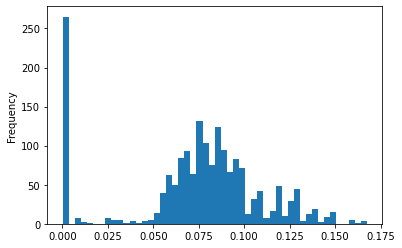

In [44]:
# Смотрим распеределение
bonds.COUPONPERCENT.plot(kind='hist',bins=50)

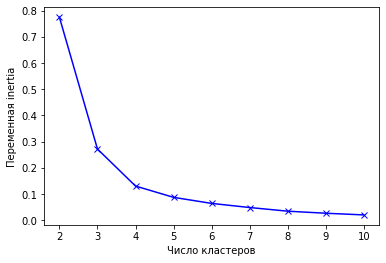

In [45]:
# Используя метод плеча определяем оптимально колличество кластеров
dist = []
K=range(2,11)
for k in K:
    model = KMeans(n_clusters=k,random_state=2056)
    model.fit(bonds[['COUPONPERCENT']])
    dist.append(model.inertia_)
plt.plot(K,dist,'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Переменная inertia')
plt.show()

In [46]:
#Оптимально колличество - 4 кластера. Т.к. после этого значения резкие переходы на графике заканчиваются.
# Применяем метод KMeans для разбиения
kmeans = KMeans(n_clusters=4, random_state=2050)
pred=kmeans.fit_predict(bonds[['COUPONPERCENT']])
bonds['ClusterID'] = pred

In [47]:
# Смотрим результаты распределения
pd.DataFrame(bonds.ClusterID.value_counts(normalize=True))

,ClusterID
0,0.356056
3,0.333521
1,0.164507
2,0.145915


In [48]:
# Создаем датавреймы для визуализации
Bar = pd.DataFrame(bonds[['COUPONPERCENT', 'ClusterID']]).set_index('ClusterID').groupby(['ClusterID']).mean().sort_values('COUPONPERCENT')*100
Bar['Count'] = pd.DataFrame(bonds.ClusterID.value_counts(normalize=False))
Bar

,COUPONPERCENT,Count
ClusterID,,
1,0.217373,292
3,6.736296,592
0,9.017472,632
2,12.706807,259


C:\Users\nevge\AppData\Local\Temp/ipykernel_17960/3448547975.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X,Bar['COUPONPERCENT'],'bx-', color="green")


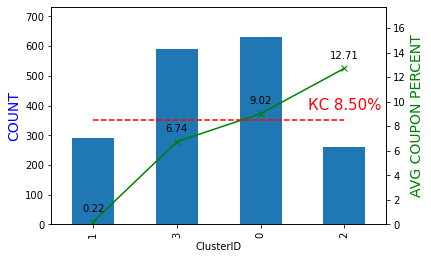

In [49]:
# Создаем визуализацию получившегося распределения
X = (Bar.sort_index().index.values).tolist()
Y = Bar['Count'].max()+100
ax = Bar['Count'].plot(kind='bar')
ax.set_ylabel("COUNT",color="blue",fontsize=14)
ax.set_ylim(0,Y)
plt.xlabel('ClusterID')
ax2=ax.twinx()
Y = Bar['COUPONPERCENT'].max()+5
plt.plot(X,Bar['COUPONPERCENT'],'bx-', color="green")
plt.plot(X, [Key_Rate*100 for i in X], ls = '--', color="red", label = 'Key_Rate')
ax2.set_ylabel("AVG COUPON PERCENT",color="green",fontsize=14)
ax2.set_ylim(0,Y)
for x,y in zip(Bar.sort_index().index.values,Bar['COUPONPERCENT']):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', color="black", fontsize=10)
plt.annotate("КС {:.2f}%".format(Key_Rate*100), (X[-1],Key_Rate*100), textcoords="offset points", xytext=(0,10), ha='center', color="red", fontsize=15)
plt.show()



In [50]:
# низкорисковые рублевые облигации с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты 
bonds_1 = bonds[bonds['HIGH_RISK'] == 0]
bonds_1 = bonds_1[bonds_1['COUPONDAYSPASSED']/bonds_1['COUPONLENGTH'] <= 0.2]
bonds_1

,SECID,SHORTNAME,NAME,TYPENAME,FACEVALUE,FACEUNIT,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE,PRICE_RUB,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,LISTLEVEL,IS_QUALIFIED_INVESTORS,DAYSTOREDEMPTION,ClusterID
2218,RU000A103ZN8,ОткрФКИОП3,ПАО ОТКРЫТИЕ ФК Банк БО-ИО-П03,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.7998,799.80,0,2022-11-25,59.0,365.0,3.0,0,1036.0,1
2216,RU000A103ZH0,СберИОС487,СберИОС 001Р-487R 3Г SPX,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.9194,919.40,0,2022-11-29,55.0,365.0,3.0,0,1041.0,1
2207,RU000A103YF7,БКСБ1Р-01,БКС Банк 001Р-01,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.9048,904.80,0,2022-11-18,66.0,365.0,3.0,0,1029.0,1
2205,RU000A103Y57,СберИОС485,СберИОС 001Р-485R 5Г IMOEX,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.8618,861.80,0,2022-11-14,69.0,364.0,3.0,0,1755.0,1
1901,RU000A1031A5,ВТБ Б1-210,Банк ВТБ (ПАО) Б-1-210,Биржевые облигации,1000.00,RUB,2.0,0.0500,0.0001,0.9411,941.11,0,2022-06-29,25.0,182.0,3.0,1,157.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592,XS2072914125,BCS12/24-4,BCS SP Plc Series 63,Корпоративные еврооблигации,100000.00,RUB,2.0,6980.8219,0.1400,0.9793,97930.00,0,2022-06-30,24.0,182.0,3.0,1,1072.0,2
213,RU000A0JVM81,Оренб35003,Оренбургская область 35003 об.,Региональные облигации,800.00,RUB,4.0,27.9200,0.1400,1.0735,864.32,0,2022-04-07,17.0,91.0,1.0,0,1257.0,2
2325,RU000A104EP6,НЗРМ БО-01,НЗРМ ООО БО-01,Биржевые облигации,1000.00,RUB,12.0,12.1200,0.1475,1.0269,1029.73,0,2022-02-16,6.0,30.0,3.0,0,1794.0,2
835,RU000A100AA4,ТАЛАНФБ1P1,ТАЛАН-ФИНАНС БО 001Р-01,Биржевые облигации,500.00,RUB,4.0,18.7000,0.1500,1.0031,502.37,0,2022-04-21,3.0,91.0,3.0,0,88.0,2


In [810]:
# Низкорисковые рублевые облигации выпущенные не более 20% купонного периода назад до текущей даты 
# Таких нет


In [51]:
# Рассчитываем НКД и Profit
bonds_1['НКД']=(bonds_1['COUPONDAYSPASSED']/bonds_1['COUPONLENGTH'] * bonds_1['COUPONPERCENT']/bonds_1['COUPONFREQUENCY'])*bonds_1['FACEVALUE']
bonds_1['Profit']=(bonds_1['FACEVALUE'] - bonds_1['PRICE_RUB'] - bonds_1['НКД'] + 0.87 * bonds_1['COUPONVALUE'] * bonds_1['COUPONFREQUENCY'] * 1)/(bonds_1['PRICE_RUB'] + bonds_1['НКД'])
bonds_1

,SECID,SHORTNAME,NAME,TYPENAME,FACEVALUE,FACEUNIT,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE,...,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,LISTLEVEL,IS_QUALIFIED_INVESTORS,DAYSTOREDEMPTION,ClusterID,НКД,Profit
2218,RU000A103ZN8,ОткрФКИОП3,ПАО ОТКРЫТИЕ ФК Банк БО-ИО-П03,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.7998,...,0,2022-11-25,59.0,365.0,3.0,0,1036.0,1,0.016164,0.250396
2216,RU000A103ZH0,СберИОС487,СберИОС 001Р-487R 3Г SPX,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.9194,...,0,2022-11-29,55.0,365.0,3.0,0,1041.0,1,0.015068,0.087743
2207,RU000A103YF7,БКСБ1Р-01,БКС Банк 001Р-01,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.9048,...,0,2022-11-18,66.0,365.0,3.0,0,1029.0,1,0.018082,0.105291
2205,RU000A103Y57,СберИОС485,СберИОС 001Р-485R 5Г IMOEX,Биржевые облигации,1000.00,RUB,1.0,0.1000,0.0001,0.8618,...,0,2022-11-14,69.0,364.0,3.0,0,1755.0,1,0.018956,0.160437
1901,RU000A1031A5,ВТБ Б1-210,Банк ВТБ (ПАО) Б-1-210,Биржевые облигации,1000.00,RUB,2.0,0.0500,0.0001,0.9411,...,0,2022-06-29,25.0,182.0,3.0,1,157.0,1,0.006868,0.062660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592,XS2072914125,BCS12/24-4,BCS SP Plc Series 63,Корпоративные еврооблигации,100000.00,RUB,2.0,6980.8219,0.1400,0.9793,...,0,2022-06-30,24.0,182.0,3.0,1,1072.0,2,923.076923,0.134478
213,RU000A0JVM81,Оренб35003,Оренбургская область 35003 об.,Региональные облигации,800.00,RUB,4.0,27.9200,0.1400,1.0735,...,0,2022-04-07,17.0,91.0,1.0,0,1257.0,2,5.230769,0.031753
2325,RU000A104EP6,НЗРМ БО-01,НЗРМ ООО БО-01,Биржевые облигации,1000.00,RUB,12.0,12.1200,0.1475,1.0269,...,0,2022-02-16,6.0,30.0,3.0,0,1794.0,2,2.458333,0.091402
835,RU000A100AA4,ТАЛАНФБ1P1,ТАЛАН-ФИНАНС БО 001Р-01,Биржевые облигации,500.00,RUB,4.0,18.7000,0.1500,1.0031,...,0,2022-04-21,3.0,91.0,3.0,0,88.0,2,0.618132,0.123438


In [52]:
# Отсекаем по 5% с каждой сторны, чтобы убрать чрезмерные значения
Bonds_profit=bonds_1[['SECID', 'NAME', 'FACEVALUE', 'COUPONFREQUENCY', \
            'COUPONVALUE', 'COUPONPERCENT', 'PRICE_RUB', 'HIGH_RISK', 'COUPONDATE', 'LISTLEVEL', \
                     'DAYSTOREDEMPTION', 'Profit']]
d = []
for i in Bonds_profit['DAYSTOREDEMPTION']:
    d.append(date.today() + timedelta(days = i))
Bonds_profit['DAYOFREDEMPTION'] = d
Bonds_profit=Bonds_profit.sort_values(by='Profit')
Bonds_profit['Profit'] = Bonds_profit['Profit']* 100
Bonds_profit['COUPONPERCENT'] = Bonds_profit['COUPONPERCENT']* 100


C:\Users\nevge\AppData\Local\Temp/ipykernel_17960/2852591419.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bonds_profit['DAYOFREDEMPTION'] = d


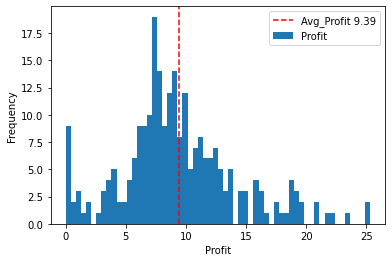

,SECID,NAME,FACEVALUE,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE_RUB,HIGH_RISK,COUPONDATE,LISTLEVEL,DAYSTOREDEMPTION,Profit,DAYOFREDEMPTION
474,RU000A0NNEG9,Банк ВТБ (ПАО) Б-1-194,1000.00,2.0,0.0500,0.010,1169.71,0,2022-06-22,3.0,888.0,-14.501929,2024-06-29
124,RU000A0JUCX1,ИА ПСПб ЗАО об.кл.А,4.34,4.0,0.0900,8.500,5.41,0,2022-04-15,3.0,7113.0,-14.119045,2041-07-15
1353,RU000A101TH7,Банк ВТБ (ПАО) Б-1-83,1000.00,2.0,0.0500,0.010,1138.51,0,2022-07-05,3.0,891.0,-12.158662,2024-07-02
1333,RU000A101SN7,Банк ВТБ (ПАО) Б-1-79,1000.00,2.0,0.0500,0.010,1095.91,0,2022-06-21,3.0,1241.0,-8.744447,2025-06-17
48,RU000A0JS926,Евразийский банк развития 10,1000.00,2.0,61.0800,12.250,1164.26,0,2022-07-12,1.0,352.0,-5.308512,2023-01-10
1352,RU000A101TG9,Банк ВТБ (ПАО) Б-1-82,1000.00,2.0,0.0500,0.010,1048.81,0,2022-06-28,3.0,530.0,-4.646200,2023-07-07
561,RU000A0ZYM54,Центральная ППК АО П01-БО-01,1000.00,1.0,75.2900,7.550,1106.63,0,2022-12-21,3.0,2152.0,-4.290529,2027-12-15
2364,SU29010RMFS4,ОФЗ-ПК 29010 06/12/34,1000.00,2.0,40.5900,8.140,1079.86,0,2022-06-22,1.0,4700.0,-1.507746,2034-12-06
1329,RU000A101SJ5,Банк ВТБ (ПАО) Б-1-78,1000.00,2.0,0.0500,0.010,1003.91,0,2022-06-28,3.0,530.0,-0.381520,2023-07-07
2261,RU000A104594,Банк ВТБ (ПАО) Б-1-280,1000.00,2.0,0.0500,0.010,1000.01,0,2022-06-24,3.0,1071.0,0.006876,2024-12-29


In [53]:
# Создаем гистограмму, чтобы увидет распределение облигаций по доходности
Bonds_profit_hist=Bonds_profit[Bonds_profit['Profit'].between(Bonds_profit['Profit'].tolist()[int(len(Bonds_profit['Profit'])*0.05)], Bonds_profit['Profit'].tolist()[int(len(Bonds_profit['Profit'])*0.95)])]
ax=Bonds_profit_hist.Profit.plot(kind='hist',bins=60)
plt.axvline(x=Bonds_profit_hist['Profit'].mean(), ls = '--', color="red", label = 'Avg_Profit {}'.format(str(Bonds_profit_hist['Profit'].mean())[0:4]))
plt.xlabel('Profit')
ax.legend(loc='upper right')
plt.show()
# отображаем весь массив
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Bonds_profit)

In [ ]:
# используем стороннюю бибилиотеку для более удобного отображения данных
tabloo.show(Bonds_profit)

In [54]:
# Формируем инвестиционную стротегию:
#Будем выступать пассивным инвестором, облигации берем как доболнительный инструмент диверсификации портфеля, инвестируем на длительный срок. Следовательно:
# - Купонные выплаты должны быть как можно чаще (от 4 раз в год)
# - Купонная ставка должна быть выше Среднего банковского депозита
# - Качество бумаг (листинг) должен быть не менее 2
# - profit выше текущей инфляции
# - гашение в течении 3-х лет
# - бумага для не квалифицированных инвесторов
# - Исходя из данных факторов выбираем 5 облигаций с максимальным profit
Strategy = bonds_1[(bonds_1.COUPONFREQUENCY >= 4) & (bonds_1.COUPONPERCENT >= avg_deposite) & (bonds_1.LISTLEVEL <= 2) & (bonds_1.Profit >= Inflation) & (bonds_1.DAYSTOREDEMPTION <= 365*3) & (bonds_1.IS_QUALIFIED_INVESTORS == 0)].sort_values(by='Profit', ascending=False).head(5).sort_values(by='DAYSTOREDEMPTION')
d = []
for i in Strategy['DAYSTOREDEMPTION']:
    d.append(date.today() + timedelta(days = i))
Strategy['DAYOFREDEMPTION'] = d
Strategy = Strategy.append({'NAME' : 'Avg Bank Deposite', 'COUPONPERCENT' : avg_deposite, 'Profit' : avg_deposite}, ignore_index=True)
Strategy = Strategy.set_index('NAME')
Strategy

,SECID,SHORTNAME,TYPENAME,FACEVALUE,FACEUNIT,COUPONFREQUENCY,COUPONVALUE,COUPONPERCENT,PRICE,PRICE_RUB,...,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,LISTLEVEL,IS_QUALIFIED_INVESTORS,DAYSTOREDEMPTION,ClusterID,НКД,Profit,DAYOFREDEMPTION
NAME,,,,,,,,,,,,,,,,,,,,,
АО ЭР-Телеком Холдинг ПБО-04,RU000A1029P7,ТелХолПБО4,Биржевые облигации,1000.0,RUB,4.0,19.70,0.07900,0.9766,977.25,...,2022-04-22 00:00:00,2.0,91.0,2.0,0.0,271.0,0.0,0.434066,0.092946,2022-10-21
ЭР-Телеком Холдинг ПБО-02-01,RU000A103WR6,ТелХолБ2-1,Биржевые облигации,1000.0,RUB,4.0,23.68,0.09500,0.9868,987.58,...,2022-04-22 00:00:00,2.0,91.0,2.0,0.0,635.0,0.0,0.521978,0.095440,2023-10-20
АО ЭР-Телеком Холдинг ПБО-05,RU000A1030K6,ТелХолПБО5,Биржевые облигации,1000.0,RUB,4.0,20.94,0.08400,0.9494,951.01,...,2022-04-18 00:00:00,6.0,91.0,2.0,0.0,813.0,0.0,1.384615,0.126499,2024-04-15
"""Сэтл-Групп"" ООО БО-001P-03",RU000A1030X9,СэтлГрБ1P3,Биржевые облигации,1000.0,RUB,4.0,21.19,0.08500,0.9454,946.56,...,2022-04-20 00:00:00,4.0,91.0,2.0,0.0,815.0,0.0,0.934066,0.133243,2024-04-17
Красноярский край обл.13,RU000A0ZYCM2,КрасЯрКр13,Региональные облигации,1000.0,RUB,4.0,19.57,0.07850,0.9694,973.27,...,2022-04-07 00:00:00,17.0,91.0,1.0,0.0,984.0,3.0,3.666209,0.093320,2024-10-03
Avg Bank Deposite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07738,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077380,NaN


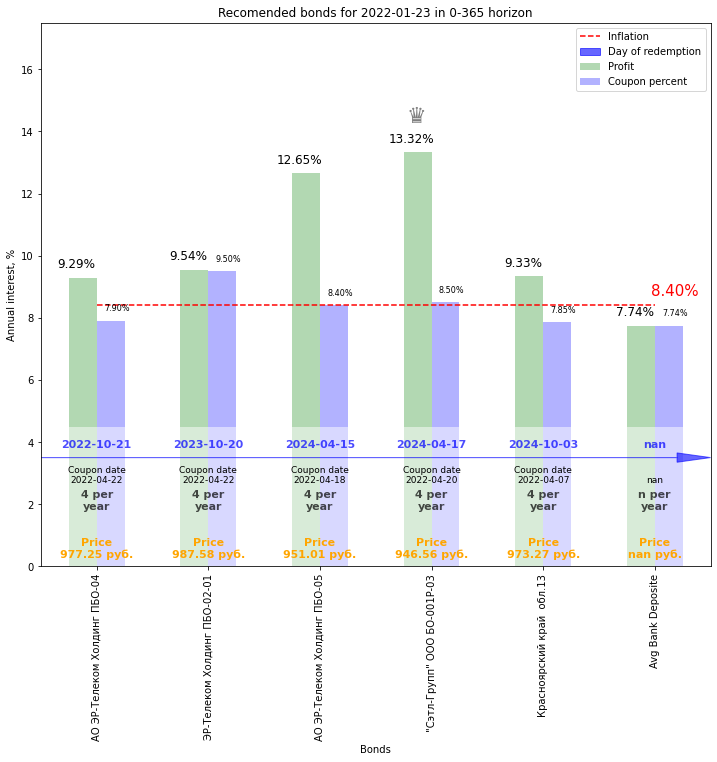

NAME
АО ЭР-Телеком Холдинг ПБО-04    RU000A1029P7
ЭР-Телеком Холдинг ПБО-02-01    RU000A103WR6
АО ЭР-Телеком Холдинг ПБО-05    RU000A1030K6
"Сэтл-Групп" ООО БО-001P-03     RU000A1030X9
Красноярский край  обл.13       RU000A0ZYCM2
Avg Bank Deposite                        NaN
Name: SECID, dtype: object

In [57]:
X = Strategy.index.tolist()
Y = Strategy['COUPONPERCENT'].max()*100+8
date_y_pos=Y/5
ax = (pd.DataFrame({'Profit':Strategy['Profit'], 'Coupon percent':Strategy['COUPONPERCENT']}, index=Strategy.index)*100).plot(kind='bar', color=["green", "blue"], alpha=0.3, figsize=(12,10), title='Recomended bonds for {} in 0-365 horizon'.format(date.today()))
ax.set_ylim(0,Y)
ax.set_ylabel("Annual interest, %")

plt.xlabel('Bonds')
inf = plt.plot(X, [Inflation*100 for i in X], ls = '--', color="red", label = 'Inflation')
ax.add_patch(Rectangle((-1, 0), 6.5, date_y_pos+1, facecolor = 'white', fill=True, lw=5, alpha=0.5))
redem = plt.arrow(-1, date_y_pos, 6.5, 0, head_width = 0.3, head_length = 0.3, length_includes_head=True, color = 'blue', alpha=0.6, label = 'Day of redemption')

for x,y in zip(X,Strategy['Profit']*100):
    label = "{:.2f}%".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(-20,10), ha='center', color="black", fontsize=12)
for x,y in zip(X,Strategy['COUPONPERCENT']*100):
    label = "{:.2f}%".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(20,10), ha='center', color="black", fontsize=8)

plt.annotate("{:.2f}%".format(Inflation*100), (X[-1],Inflation*100), textcoords="offset points", xytext=(20,10), ha='center', color="red", fontsize=15)
plt.annotate("♛", (Strategy[Strategy['Profit']==Strategy['Profit'].max()].index,Strategy['Profit'].max()*100), textcoords="offset points", xytext=(-15,30), ha='center', color="black", fontsize=22, alpha=0.5, weight="bold")
for x in X:
    label = Strategy['DAYOFREDEMPTION'][x]
    plt.annotate(label, (x, date_y_pos), textcoords="offset points", xytext=(0,10), ha='center', color="blue", fontsize=11, weight="bold", alpha = 0.7)
    label = Strategy['COUPONDATE'][x]
    if type(label) != float:
        label = "Coupon date\n{:}".format(label.strftime("%Y-%m-%d"))
    plt.annotate(label, (x, date_y_pos), textcoords="offset points", xytext=(0,-25), ha='center', color="black", fontsize=9)
    label = "{:} per\nyear".format(str(Strategy['COUPONFREQUENCY'][x])[0])
    plt.annotate(label, (x, date_y_pos), textcoords="offset points", xytext=(0,-52), ha='center', color="black", fontsize=11, weight="bold", alpha = 0.7)
    label = "Price\n{:} руб.".format(Strategy['PRICE_RUB'][x])
    plt.annotate(label, (x, date_y_pos), textcoords="offset points", xytext=(0,-100), ha='center', color="orange", fontsize=11, weight="bold")
leg = ax.legend(loc='upper right')
plt.show()
Strategy['SECID']
